In [62]:
import sys
import os
import toml

import torch
import torcharrow
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe

import pandas as pd
import numpy as np
import scipy.optimize as SciOpt
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from tqdm.notebook import tqdm

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from data.kcost_dataset import KCostDataSet
from model.kcost import KCostModel
from model.tierlevelcost import TierLevelCost
from lsm.lsmtype import Policy
from jobs.train import TrainJob
import lsm.cost as CostFunc

In [63]:
config = Reader.read_config('../../endure.toml')

In [306]:
model_path = '/data/tiercost-10-27'
config_model = Reader.read_config(os.path.join(model_path, 'config.toml'))

workload = config_model['workloads'][14]
z0, z1, q, w = (workload['z0'], workload['z1'], workload['q'], workload['w'])
cf = CostFunc.EndureTierLevelCost(**config_model['system'])
analytical_cf = lambda h, T: cf.calc_cost(h, T, Policy.Tiering, z0, z1, q, w)

workload

{'id': 14, 'z0': 0.01, 'z1': 0.33, 'q': 0.33, 'w': 0.33}

In [307]:
tj = TrainJob(config_model)
model = tj._build_model()
model_data = torch.load(os.path.join(model_path, 'kcost_min.model'), map_location=torch.device('cpu'))
load_status = model.load_state_dict(model_data)
model.eval()
load_status

<All keys matched successfully>

In [308]:
def cost_func_objective(args):
    h, T = args[0], args[1]
    return analytical_cf(h, T)

def cost_func_learned(args):
    h, T = args[0], args[1]
    fraction = T - np.floor(T)
    row = [0, 0, 0, 0, h, z0, z1, q, w] + [np.floor(T)]
    row_next = [0, 0, 0, 0, h, z0, z1, q, w] + [np.ceil(T)]
    _, inputs = tj._process_row(row)
    _, inputs_next = tj._process_row(row_next)
    inputs = torch.from_numpy(inputs.reshape(1, -1))
    inputs_next = torch.from_numpy(inputs_next.reshape(1, -1))
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item() * (1 - fraction)
#         pred = pred.sum().item()
        pred_next = model(inputs_next)
        pred_next = pred_next.sum().item() * (fraction)
        pred += pred_next

    return pred

In [314]:
one_mib_in_bits = 1024 * 1024 * 8
T_UPPER_LIM = config_model['lsm']['size_ratio']['max']
T_LOWER_LIM = config_model['lsm']['size_ratio']['min']
H_UPPER_LIM = config_model['lsm']['bits_per_elem']['max']
max_levels = config_model['lsm']['max_levels']

h_initial = 9.
T_initial = 5.
# K_initial = [1.] * max_levels

h_bounds = (0, H_UPPER_LIM)
T_bounds = (T_LOWER_LIM, T_UPPER_LIM)
# K_bounds = [(T_LOWER_LIM - 1, T_UPPER_LIM - 1)] * max_levels

# bounds = [h_bounds, T_bounds] + K_bounds
bounds = [h_bounds, T_bounds]
min_cost = np.inf
design = {}
minimizer_kwargs = {
    'method' : 'SLSQP',
    'bounds' : bounds,
    'options': {'ftol': 1e-6, 'eps': 1e-6, 'disp': True}}
#     'options': {'ftol': 1e-9, 'disp': True}}
# x0 = np.array([h_initial, T_initial] + K_initial)
x0 = np.array([h_initial, T_initial])

In [310]:
cost_func_learned(x0), cost_func_objective(x0)

(8.279741287231445, 8.658929990309973)

In [325]:
analytical_sol = SciOpt.minimize(
    fun=cost_func_objective,
    x0=x0,
    **minimizer_kwargs
)
analytical_sol

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.455202064104395
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9


     fun: 5.455202064104395
     jac: array([ 9.86899451e-05, -3.46673801e-04])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.06198561, 2.10020871])

In [326]:
learned_sol = SciOpt.minimize(
    fun=cost_func_learned,
    x0=x0,
    **minimizer_kwargs
)
learned_sol

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.210841178894044
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7


     fun: 4.210841178894044
     jac: array([0.       , 0.8467803])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([3.200162, 2.      ])

In [330]:
analytical_args_floor = [analytical_sol.x[0], np.floor(analytical_sol.x[1])]
analytical_args_ceil = [analytical_sol.x[0], np.ceil(analytical_sol.x[1])]
print(analytical_args_floor)
print(analytical_args_ceil)
print(learned_sol.x)
cost_func_objective(learned_sol.x), cost_func_objective(analytical_args_floor), cost_func_objective(analytical_args_ceil)

[2.061985605925821, 2.0]
[2.061985605925821, 3.0]
[3.200162 2.      ]


(5.49973097204468, 5.464313942222028, 5.799611114859259)

In [331]:
df = []
args = np.array([3, T_initial])
for t in np.arange(2, 49, 1):
    args[1] = t
    df.append({
        'T': t,
        'learned': cost_func_learned(args),
        'analytical': cost_func_objective(args)
    })
df = pd.DataFrame(df)

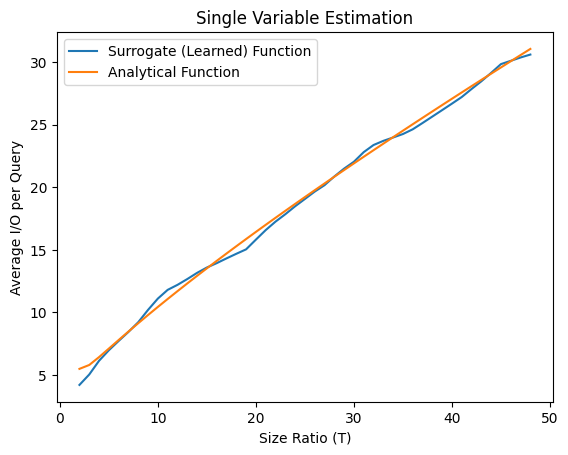

In [332]:
x = df['T']
y_learned = df['learned']
y_analytical = df['analytical']

fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
None